In [1]:
import sys; sys.path.append('/home/clair/wwa')
from wwa import *
from wwa_nonstationary_fitting import *

## **Event definition**

## **CPC**

In [35]:
# cut out relevant region
# xr.open_mfdataset("../../Data/cpc/precip.*.nc").sel(lat = slice(-32,-49), lon = slice(165,180)).precip.load().to_netcdf("data/cpc-precip-daily.nc")

In [12]:
cpc = xr.open_dataset("data/cpc-precip-daily.nc").precip

In [13]:
cpc_3day = cpc.rolling(time = 3).mean().resample(time = "AS-MAR", label = "right").max().resample(time = "AS-JAN").mean()
cpc_5day = cpc.rolling(time = 5).mean().resample(time = "AS-MAR", label = "right").max().resample(time = "AS-JAN").mean()
cpc_7day = cpc.rolling(time = 7).mean().resample(time = "AS-MAR", label = "right").max().resample(time = "AS-JAN").mean()

In [14]:
gmst = pd.read_csv("/home/clair/wwa/90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["time","gmst"], parse_dates = True, index_col = "time").to_xarray().gmst
gmst = gmst.sel(time = cpc_3day.time)

In [15]:
cpc_3day_fit = ns_mapfit(gev, "fixeddisp", cpc_3day, gmst)
cpc_5day_fit = ns_mapfit(gev, "fixeddisp", cpc_5day, gmst)
cpc_7day_fit = ns_mapfit(gev, "fixeddisp", cpc_7day, gmst)

In [16]:
stn_data = pd.read_csv("data/stations.csv", index_col = "Agent Number")

Text(0.5, 0.98, 'Return periods of 2023 event - CPC (data up to Feb 14th)')

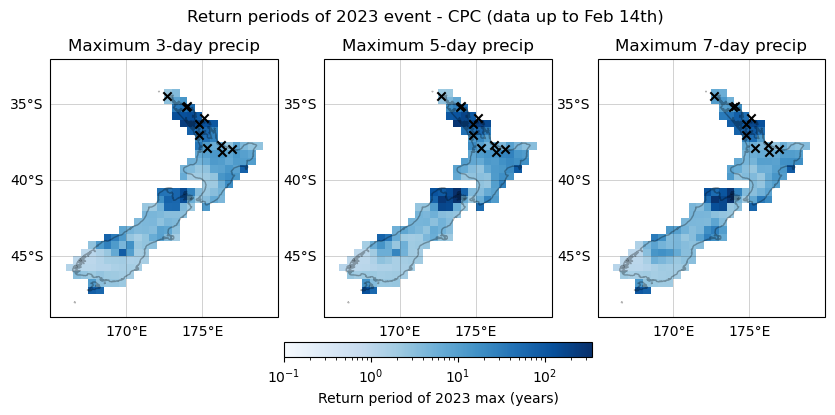

In [17]:
fig, axs = plt.subplots(ncols = 3, dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (10,4))

plot_kwargs = {"add_colorbar" : False, "vmin" : 0.1, "vmax" : 350, "cmap" : "Blues"} | {"norm" : matplotlib.colors.LogNorm()}

rpmap(cpc_3day_fit.ml_fit, cpc_3day.sel(time = "2023"), gmst.sel(time = "2023"), lower = False).plot(ax = axs[0], **plot_kwargs)
rpmap(cpc_5day_fit.ml_fit, cpc_5day.sel(time = "2023"), gmst.sel(time = "2023"), lower = False).plot(ax = axs[1], **plot_kwargs)
cbar = rpmap(cpc_7day_fit.ml_fit, cpc_7day.sel(time = "2023"), gmst.sel(time = "2023"), lower = False).plot(ax = axs[2], **plot_kwargs)

axs[0].set_title("Maximum 3-day precip")
axs[1].set_title("Maximum 5-day precip")
axs[2].set_title("Maximum 7-day precip")

for ax in axs:
    ax.coastlines(alpha = 0.3)
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.25, xlocs = range(165, 180, 5), ylocs = range(-30,-50,-5))
    ax.scatter(stn_data.lon, stn_data.lat, marker = "x", color = "k")
    
plt.colorbar(cbar, ax = axs, location = "bottom", shrink = 0.9, fraction = 0.05, pad = 0.08, label = "Return period of 2023 max (years)")

plt.suptitle("Return periods of 2023 event - CPC (data up to Feb 14th)")

In [19]:
cpc_3day_fit.ml_fit.sel(pars = "alpha")

<xarray.DataArray 'ml_fit' (lat: 34, lon: 30)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 -32.25 -32.75 -33.25 -33.75 ... -47.75 -48.25 -48.75
  * lon      (lon) float32 165.2 165.8 166.2 166.8 ... 178.2 178.8 179.2 179.8
    pars     <U6 'alpha'
Attributes: (12/14)
    var_desc:      Precipitation
    level_desc:    Surface
    statistic:     Total
    parent_stat:   Other
    long_name:     Daily total of precipitation
    cell_methods:  time: sum
    ...            ...
    units:         mm
    valid_range:   [   0. 1000.]
    dataset:       CPC Global Precipitation
    dist:          genextreme
    fittype:       fixeddisp
    solver:        Nelder-Mead

Text(0.5, 0.98, 'Fitted trends in extreme precip - CPC (data up to Feb 14th)')

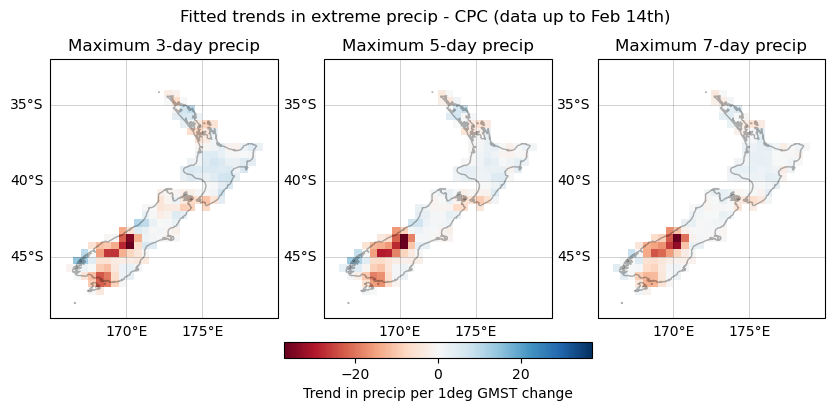

In [29]:
fig, axs = plt.subplots(ncols = 3, dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (10,4))

plot_kwargs = {"add_colorbar" : False, "cmap" : "RdBu"}

cpc_3day_fit.ml_fit.sel(pars = "alpha").plot(ax = axs[0], **plot_kwargs)
cpc_5day_fit.ml_fit.sel(pars = "alpha").plot(ax = axs[1], **plot_kwargs)
cbar = cpc_7day_fit.ml_fit.sel(pars = "alpha").plot(ax = axs[2], **plot_kwargs)

axs[0].set_title("Maximum 3-day precip")
axs[1].set_title("Maximum 5-day precip")
axs[2].set_title("Maximum 7-day precip")

for ax in axs:
    ax.coastlines(alpha = 0.3)
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.25, xlocs = range(165, 180, 5), ylocs = range(-30,-50,-5))
    # ax.scatter(stn_data.lon, stn_data.lat, marker = "x", color = "k")
    
plt.colorbar(cbar, ax = axs, location = "bottom", shrink = 0.9, fraction = 0.05, pad = 0.08, label = "Trend in precip per 1deg GMST change")

plt.suptitle("Fitted trends in extreme precip - CPC (data up to Feb 14th)")

---
### **Identify affected region (IMERG)**

In [71]:
imerg = xr.open_dataset("data/imerg_daily_05_165-180E_-30--50N_su.nc").precipitationCal

In [82]:
imerg_3day, imerg_5day, imerg_7day = [imerg.rolling(time = n).mean().resample(time = "AS-MAR", label = "right").max().resample(time = "AS-JAN").mean() for n in [3,5,7]]

In [83]:
gmst = pd.read_csv("/home/clair/wwa/90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["time","gmst"], parse_dates = True, index_col = "time").to_xarray().gmst
gmst = gmst.sel(time = imerg_3day.time)

In [84]:
imerg_3day_fit, imerg_5day_fit, imerg_7day_fit = [ns_mapfit(gev, "fixeddisp", da, gmst) for da in [imerg_3day, imerg_5day, imerg_7day]]

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/scipy/optimize/_optimize.py:811: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


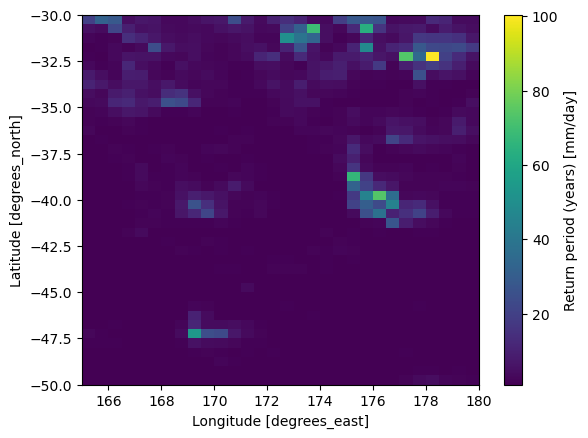

In [87]:
rpmap(imerg_3day_fit.ml_fit, imerg_3day.sel(time = "2023"), gmst.sel(time = "2023"), lower = False).plot()

Text(0.5, 0.98, 'Return periods of 2023 event - IMERG (data up to Feb 12th)')

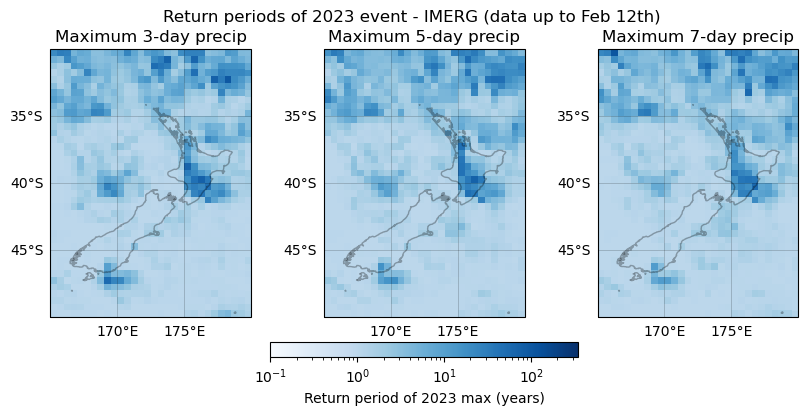

In [88]:
fig, axs = plt.subplots(ncols = 3, dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (10,4))

plot_kwargs = {"add_colorbar" : False, "vmin" : 0.1, "vmax" : 350, "cmap" : "Blues"} | {"norm" : matplotlib.colors.LogNorm()}

rpmap(imerg_3day_fit.ml_fit, imerg_3day.sel(time = "2023"), gmst.sel(time = "2023"), lower = False).plot(ax = axs[0], **plot_kwargs)
rpmap(imerg_5day_fit.ml_fit, imerg_5day.sel(time = "2023"), gmst.sel(time = "2023"), lower = False).plot(ax = axs[1], **plot_kwargs)
cbar = rpmap(imerg_7day_fit.ml_fit, imerg_7day.sel(time = "2023"), gmst.sel(time = "2023"), lower = False).plot(ax = axs[2], **plot_kwargs)

axs[0].set_title("Maximum 3-day precip")
axs[1].set_title("Maximum 5-day precip")
axs[2].set_title("Maximum 7-day precip")

for ax in axs:
    ax.coastlines(alpha = 0.3)
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.25, xlocs = range(165, 180, 5), ylocs = range(-30,-50,-5))
    ax.set_extent((165,180,-30,-50))
    
plt.colorbar(cbar, ax = axs, location = "bottom", shrink = 0.9, fraction = 0.05, pad = 0.08, label = "Return period of 2023 max (years)")

plt.suptitle("Return periods of 2023 event - IMERG (data up to Feb 12th)")

---
## **NIWA station data**


In [2]:
stn_data = pd.concat([pd.read_csv(fnm, skiprows = 1, nrows = 1, index_col = "Agent Number") for fnm in glob.glob("data/stn-*.txt")]).rename(columns = {"Latitude (dec.deg)" : "lat", "Longitude (dec.deg)" : "lon"})
stn_data = stn_data.sort_values("lat", ascending = False)
stn_data.to_csv("data/stations.csv")

obs = reduce(lambda left, right: pd.merge(left,right,left_index = True, right_index = True, how = 'outer'),
            [pd.read_csv(fnm, skiprows = 8, index_col = "Date(NZST)", parse_dates = True)[["Amount(mm)"]].rename(columns = {"Amount(mm)" : fnm[9:-4]}) for fnm in glob.glob("data/stn-*.txt")])
obs = obs[[str(s) for s in stn_data.index.values]] # reorder by latitude
obs_3day = obs.rolling(3, center = False).mean().resample("AS-JAN").max()

gmst = pd.read_csv("/home/clair/wwa/90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"], parse_dates = True, index_col = "year")
df = pd.merge(gmst, obs_3day, left_index = True, right_index = True)

event_gmst = df.loc["2023", "gmst"].values[0]

Text(0.5, 0.98, 'Annual maximum of 3-day accumulated precipitation at selected stations')

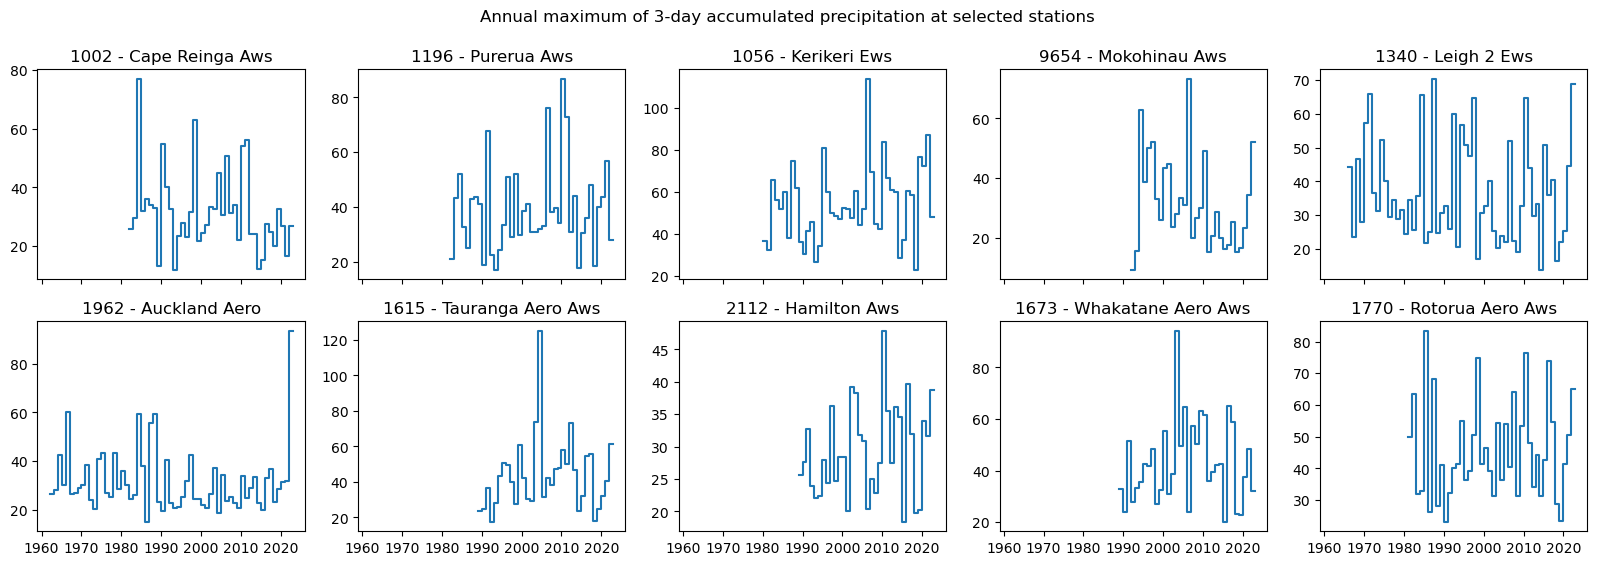

In [3]:
fig, axs = plt.subplots(ncols = 5, nrows = 2, figsize = (20,6), dpi = 100, sharex = True)

for i in range(10):
    
    ax = fig.axes[i]
    stn = obs_3day.columns[i]
    ax.step(obs_3day.index, obs_3day[[stn]])
    ax.set_title(stn+" - "+stn_data.loc[int(stn)].Name)
    
plt.suptitle("Annual maximum of 3-day accumulated precipitation at selected stations")

### **CX trend plots**

In [3]:
import warnings
warnings.filterwarnings("ignore")
# need to add a catch_warnings context manager to code to silence errors raised during fitting

In [6]:
# check return periods at each station
stn_fit = pd.DataFrame({stn : model_results(ns_fit(gev, "fixeddisp", df[["gmst", stn]].dropna(axis = 0, how = "any"), "gmst", stn, tol = 1e-5), event_gmst, event_gmst - 1.2, event_value = df.loc["2023", stn].values[0], lower = False) for stn in df.columns[1:]}).transpose()

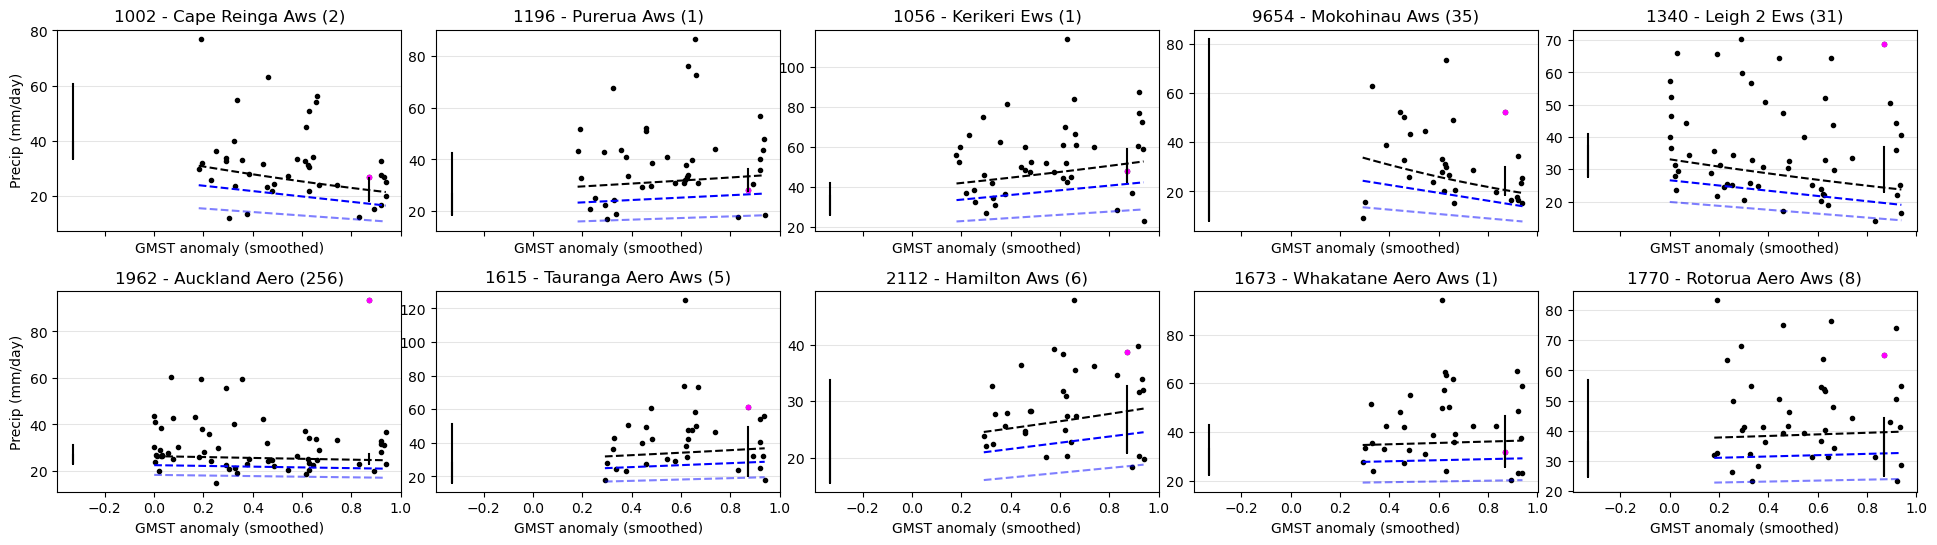

In [80]:
fig, axs = plt.subplots(ncols = 5, nrows = 2, figsize = (24,6), dpi = 100, sharex = True)
plt.subplots_adjust(hspace = 0.3, wspace = 0.1)

for i in range(10):
        
    ax = fig.axes[i]
    stn = obs_3day.columns[i]
    
    mdl = ns_fit(gev, "fixeddisp", df[["gmst", stn]].dropna(axis = 0, how = "any"), "gmst", stn, tol = 1e-5)
    rp = str(int(return_period(mdl, covariate = event_gmst, event_value = df.loc["2023", stn].values[0], lower = False)))
        
    boot_ci = boot_results(mdl, event_gmst, event_gmst - 1.2, nsamp = 10)    
    trendplot(mdl, event_gmst, event_gmst - 1.2, ax = ax, loc1 = boot_ci["loc1"].values.flatten(), loc2 = boot_ci["loc2"].values.flatten())
        
    ax.set_title(stn+" - "+stn_data.loc[int(stn)].Name+" ("+rp+")")
    ax.grid(axis = "y", color = "k", alpha = 0.1)

for ax in axs[:,0]: ax.set_ylabel("Precip (mm/day)")

plt.savefig("stations-fitted-trendplots.png")

### **CX return level plots**

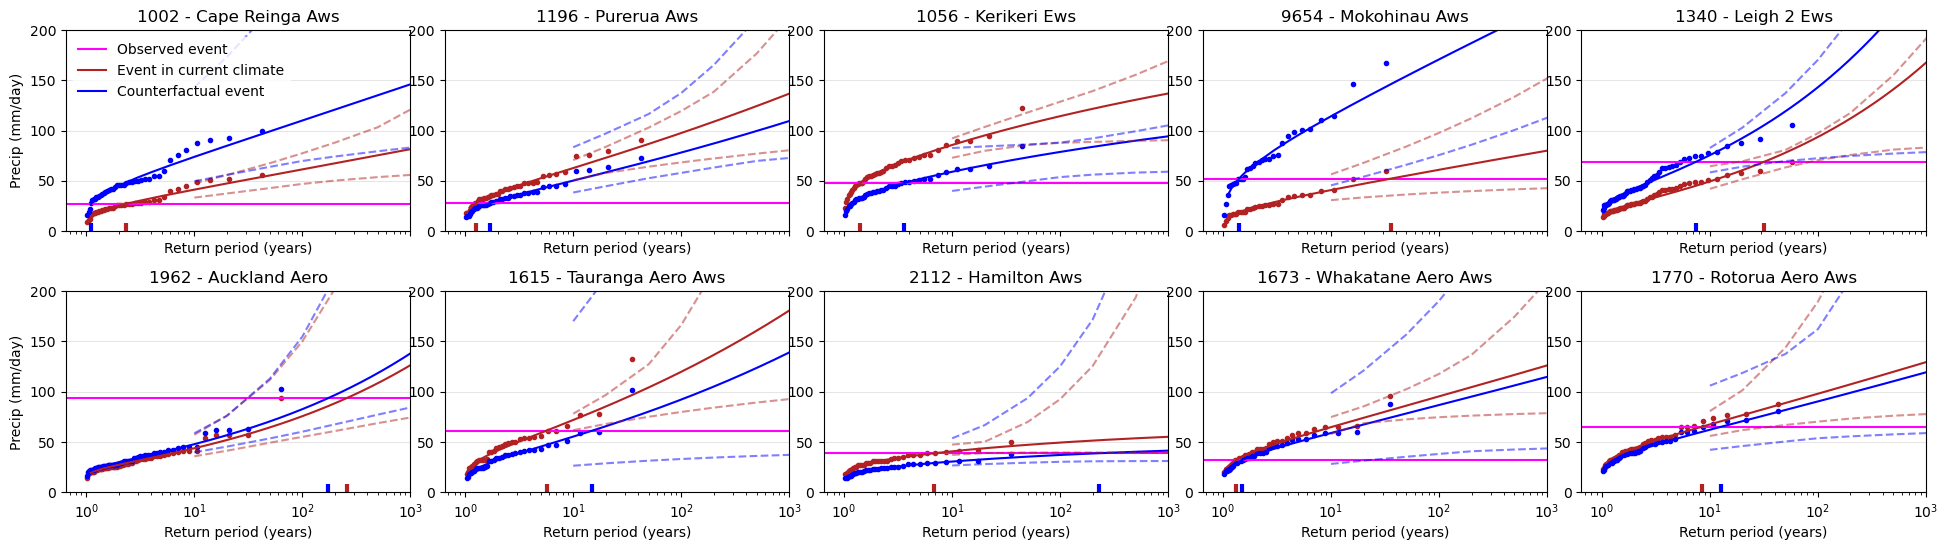

In [10]:
fig, axs = plt.subplots(ncols = 5, nrows = 2, figsize = (24,6), dpi = 100, sharex = True)
plt.subplots_adjust(hspace = 0.3, wspace = 0.1)

for i in range(len(obs.columns)):
        
    ax = fig.axes[i]
    stn = obs_3day.columns[i]
    
    mdl = ns_fit(gev, "fixeddisp", df[["gmst", stn]].dropna(axis = 0, how = "any"), "gmst", stn, tol = 1e-5)    
    rlplot(mdl, event_gmst, event_gmst - 1.2, df.loc["2023", stn].values[0], lower = False, ax = ax, legend = False)
    
    # trendplot(mdl, event_gmst, event_gmst - 1.2, ax = ax)
    ax.set_title(stn+" - "+stn_data.loc[int(stn)].Name)
    ax.grid(axis = "y", color = "k", alpha = 0.1)
    ax.set_ylim(0, 200)
    ax.set_xlim(None, 1000)
    
for ax in axs[:,0]: ax.set_ylabel("Precip (mm/day)")
axs[0,0].legend(edgecolor = "w")

plt.savefig("stations-fitted-returnperiods.png")